In [1]:
import numpy as np
import matplotlib.pyplot as plt

Configuração do matplotlib para gráficos maiores

In [2]:
plt.rcParams["figure.figsize"] = (10, 6)

===== FUNÇÕES AUXILIARES =====

In [3]:
def sigmoid(t):
    """
    Função de ativação sigmoid
    Transforma qualquer valor real em um valor entre 0 e 1
    """
    return 1 / (1 + np.exp(-t))

In [4]:
def sigmoid_derivative(p):
    """
    Derivada da função sigmoid
    Necessária para o algoritmo de backpropagation
    f'(x) = f(x) * (1 - f(x))
    """
    return sigmoid(p) * (1 - sigmoid(p))

In [5]:
def mse(y1, y2):
    """
    Função de erro quadrático médio (Mean Squared Error)
    Mede a diferença entre os valores preditos e reais
    """
    return np.mean(np.square(y1 - y2))

In [6]:
def Vc_RC(t, r=5, c=0.1, vin=1):
    """
    Tensão de um capacitor em um circuito RC série
    
    Parâmetros:
    t: tempo
    r: resistência (Ohms)
    c: capacitância (Farads)
    vin: tensão de entrada (Volts)
    
    Fórmula: Vc = Vin * (1 - e^(-t/(R*C)))
    """
    tau = -t / (r * c)
    vc = vin * (1 - np.exp(tau))
    return vc

===== CLASSE DA REDE NEURAL MLP =====

In [7]:
class NeuralNetwork:
    """
    Rede Neural Multi-Layer Perceptron com 3 camadas:
    - Camada de entrada
    - Camada oculta (hidden layer)
    - Camada de saída
    """
    
    def __init__(self, x, y, n=15):
        """
        Inicializa a rede neural
        
        Args:
            x: dados de entrada para treinamento
            y: saídas desejadas para treinamento
            n: número de neurônios na camada oculta
        """
        self.entrada = x
        
        # pesos_0: conexões entre camada de entrada e camada oculta
        self.pesos_0 = np.random.rand(self.entrada.shape[1], n)
        
        # pesos_1: conexões entre camada oculta e camada de saída
        self.pesos_1 = np.random.rand(n, 1)
        
        self.y = y
        self.saida = np.zeros(y.shape)
    
    def feedforward(self):
        """
        Calcula a saída da rede neural dados os pesos atuais
        """
        # Camada oculta
        # Potencial de ativação = entrada * pesos
        self.pot_ativ_0 = np.dot(self.entrada, self.pesos_0)
        # Saída da camada oculta = sigmoid(potencial de ativação)
        self.camada_0 = sigmoid(self.pot_ativ_0)
        
        # Camada de saída
        # Potencial de ativação = saída camada oculta * pesos
        self.pot_ativ_1 = np.dot(self.camada_0, self.pesos_1)
        # Saída final = sigmoid(potencial de ativação)
        self.camada_1 = sigmoid(self.pot_ativ_1)
        
        return self.camada_1
    
    def backprop(self):
        """
        Atualiza os pesos baseado no erro calculado
        """
        learning_rate = 0.1
        
        # Cálculo do gradiente para pesos_1 (camada de saída)
        # ∂MSE/∂W1 = 2*(y - ŷ) * sigmoid'(z1) * camada_0
        erro_saida = 2 * (self.y - self.saida)
        gradiente_saida = erro_saida * sigmoid_derivative(self.pot_ativ_1)
        d_pesos_1 = np.dot(self.camada_0.T, gradiente_saida)
        
        # Cálculo do gradiente para pesos_0 (camada oculta)
        # ∂MSE/∂W0 = 2*(y - ŷ) * sigmoid'(z1) * W1 * sigmoid'(z0) * entrada
        erro_oculta = np.dot(gradiente_saida, self.pesos_1.T)
        gradiente_oculta = erro_oculta * sigmoid_derivative(self.pot_ativ_0)
        d_pesos_0 = np.dot(self.entrada.T, gradiente_oculta)
        
        # Atualização dos pesos
        # W = W + α * ∂MSE/∂W (onde α é a taxa de aprendizagem)
        self.pesos_0 += d_pesos_0 * learning_rate
        self.pesos_1 += d_pesos_1 * learning_rate
    
    def train(self):
        """
        Um ciclo completo de treinamento (época)
        """
        self.saida = self.feedforward()
        self.backprop()
    
    def predict(self, x):
        """
        Faz predições com dados novos
        """
        entrada_original = self.entrada
        self.entrada = x
        saida = self.feedforward()
        self.entrada = entrada_original
        return saida

===== PREPARAÇÃO DOS DADOS =====

In [8]:
print("=== PREPARAÇÃO DOS DADOS ===")

=== PREPARAÇÃO DOS DADOS ===


Gerando dados da equação do capacitor RC

In [ ]:
t = np.arange(0, 3, 0.1)  # tempo de 0 a 3 segundos
vc = Vc_RC(t)             # tensão do capacitor

# Normalização do tempo (entre 0 e 1)
t_normalizado = t / np.amax(t)

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9]
[0.         0.18126925 0.32967995 0.45118836 0.55067104 0.63212056
 0.69880579 0.75340304 0.79810348 0.83470111 0.86466472 0.88919684
 0.90928205 0.92572642 0.93918994 0.95021293 0.9592378  0.96662673
 0.97267628 0.97762923 0.98168436 0.98500442 0.98772266 0.98994816
 0.99177025 0.99326205 0.99448344 0.99548342 0.99630214 0.99697245]


Divisão dos dados: 60% treino, 40% teste

In [10]:
porcent_treino = 60
tam_treino = int(len(vc) * porcent_treino / 100)

Dados de treinamento

In [11]:
x_train = t_normalizado[:tam_treino]
y_train = vc[:tam_treino]

Dados de teste

In [12]:
x_test = t_normalizado[tam_treino:]
y_test = vc[tam_treino:]

Transformando em matrizes coluna

In [13]:
x_train = x_train.reshape(tam_treino, 1)
y_train = y_train.reshape(tam_treino, 1)
x_test = x_test.reshape(len(x_test), 1)

In [14]:
print(f"Dados de treino: {len(x_train)} amostras")
print(f"Dados de teste: {len(x_test)} amostras")

Dados de treino: 18 amostras
Dados de teste: 12 amostras


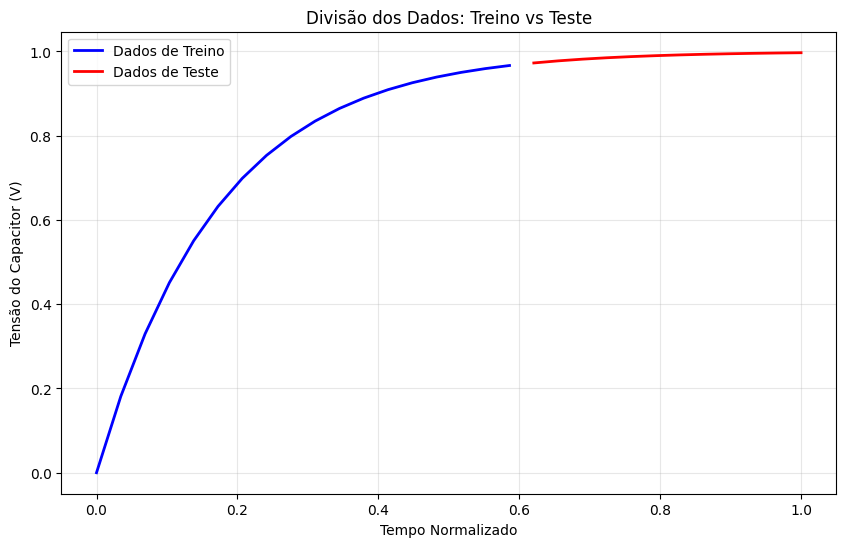

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(x_train.flatten(), y_train.flatten(), 'b-', label="Dados de Treino", linewidth=2)
plt.plot(x_test.flatten(), y_test.flatten(), 'r-', label="Dados de Teste", linewidth=2)
plt.xlabel("Tempo Normalizado")
plt.ylabel("Tensão do Capacitor (V)")
plt.title("Divisão dos Dados: Treino vs Teste")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [16]:
print("\n=== TREINAMENTO DA REDE NEURAL ===")


=== TREINAMENTO DA REDE NEURAL ===


In [17]:
nn_vc_model = NeuralNetwork(x_train, y_train, n=15)

In [18]:
plt.figure(figsize=(12, 4))

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

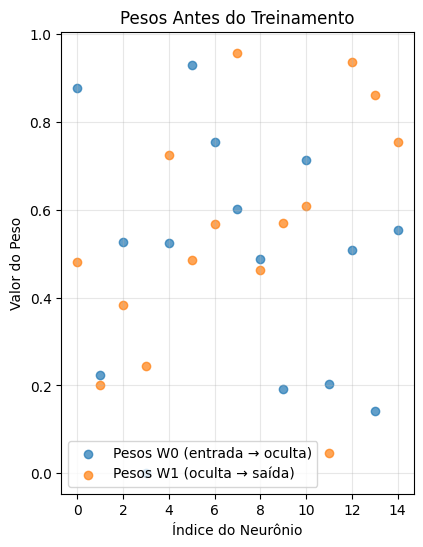

In [19]:
plt.subplot(1, 2, 1)
pesos_0_inicial = np.array(nn_vc_model.pesos_0)
pesos_1_inicial = np.array(nn_vc_model.pesos_1)
plt.scatter(range(len(pesos_0_inicial[0])), pesos_0_inicial[0], 
           label="Pesos W0 (entrada → oculta)", alpha=0.7)
plt.scatter(range(len(pesos_1_inicial.flatten())), pesos_1_inicial.flatten(), 
           label="Pesos W1 (oculta → saída)", alpha=0.7)
plt.title("Pesos Antes do Treinamento")
plt.xlabel("Índice do Neurônio")
plt.ylabel("Valor do Peso")
plt.legend()
plt.grid(True, alpha=0.3)

In [20]:
print("Iniciando treinamento...")
erro_historico = []
num_epocas = 500

Iniciando treinamento...


In [21]:
for epoca in range(num_epocas):
    # Calcular saída atual
    saida_rede = nn_vc_model.feedforward()
    
    # Calcular e armazenar erro
    erro_atual = mse(y_train, saida_rede)
    erro_historico.append(erro_atual)
    
    # Treinar (backpropagation)
    nn_vc_model.train()
    
    if (epoca + 1) % 100 == 0:
        print(f"Época {epoca + 1}/{num_epocas} - Erro MSE: {erro_atual:.6f}")

Época 100/500 - Erro MSE: 0.067591
Época 200/500 - Erro MSE: 0.046795
Época 300/500 - Erro MSE: 0.020998
Época 400/500 - Erro MSE: 0.009335
Época 500/500 - Erro MSE: 0.005375


In [22]:
print("Treinamento concluído!")

Treinamento concluído!


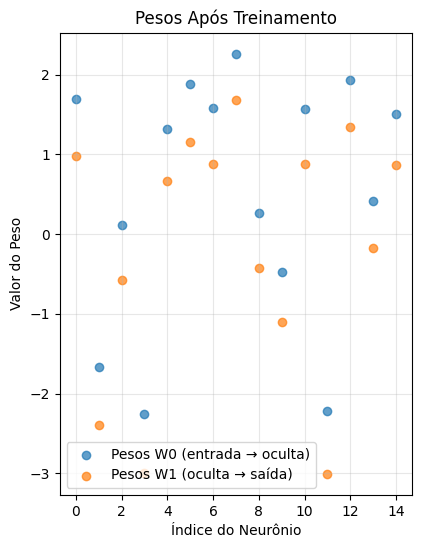

In [23]:
plt.subplot(1, 2, 2)
pesos_0_final = np.array(nn_vc_model.pesos_0)
pesos_1_final = np.array(nn_vc_model.pesos_1)
plt.scatter(range(len(pesos_0_final[0])), pesos_0_final[0], 
           label="Pesos W0 (entrada → oculta)", alpha=0.7)
plt.scatter(range(len(pesos_1_final.flatten())), pesos_1_final.flatten(), 
           label="Pesos W1 (oculta → saída)", alpha=0.7)
plt.title("Pesos Após Treinamento")
plt.xlabel("Índice do Neurônio")
plt.ylabel("Valor do Peso")
plt.legend()
plt.grid(True, alpha=0.3)

In [24]:
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

In [25]:
print("\n=== ANÁLISE DA CONVERGÊNCIA ===")


=== ANÁLISE DA CONVERGÊNCIA ===


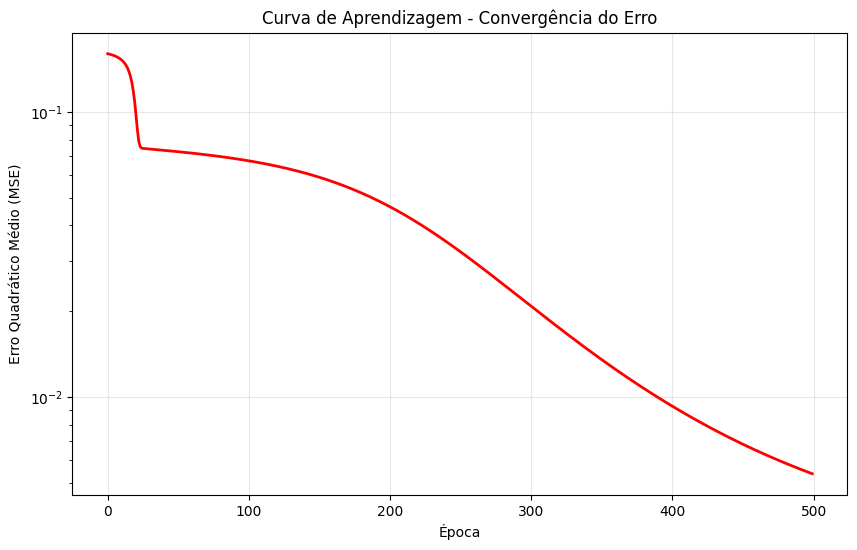

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(erro_historico, 'r-', linewidth=2)
plt.xlabel("Época")
plt.ylabel("Erro Quadrático Médio (MSE)")
plt.title("Curva de Aprendizagem - Convergência do Erro")
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.show()

In [27]:
print(f"Erro inicial: {erro_historico[0]:.6f}")
print(f"Erro final: {erro_historico[-1]:.6f}")
print(f"Redução do erro: {((erro_historico[0] - erro_historico[-1]) / erro_historico[0] * 100):.2f}%")

Erro inicial: 0.160397
Erro final: 0.005375
Redução do erro: 96.65%


In [28]:
print("\n=== TESTE E VALIDAÇÃO ===")


=== TESTE E VALIDAÇÃO ===


Fazendo predições nos dados de teste

In [29]:
predicoes_teste = nn_vc_model.predict(x_test)

Calculando métricas de performance

In [30]:
erro_teste = mse(y_test, predicoes_teste)
print(f"Erro MSE nos dados de teste: {erro_teste:.6f}")

Erro MSE nos dados de teste: 0.000125


Visualização detalhada dos resultados

In [31]:
plt.figure(figsize=(15, 5))

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

Gráfico 1: Comparação apenas nos dados de teste

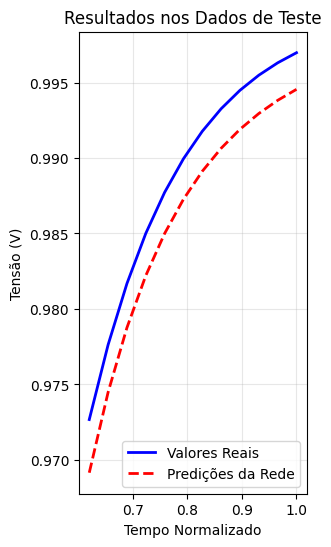

In [32]:
plt.subplot(1, 3, 1)
plt.plot(x_test.flatten(), y_test, 'b-', label="Valores Reais", linewidth=2)
plt.plot(x_test.flatten(), predicoes_teste.flatten(), 'r--', 
         label="Predições da Rede", linewidth=2)
plt.xlabel("Tempo Normalizado")
plt.ylabel("Tensão (V)")
plt.title("Resultados nos Dados de Teste")
plt.legend()
plt.grid(True, alpha=0.3)

Gráfico 2: Visão geral (treino + teste)

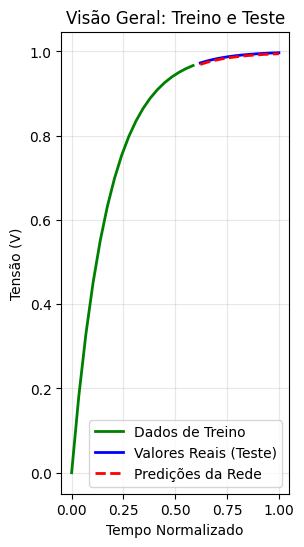

In [33]:
plt.subplot(1, 3, 2)
plt.plot(x_train.flatten(), y_train.flatten(), 'g-', label="Dados de Treino", linewidth=2)
plt.plot(x_test.flatten(), y_test, 'b-', label="Valores Reais (Teste)", linewidth=2)
plt.plot(x_test.flatten(), predicoes_teste.flatten(), 'r--', 
         label="Predições da Rede", linewidth=2)
plt.xlabel("Tempo Normalizado")
plt.ylabel("Tensão (V)")
plt.title("Visão Geral: Treino e Teste")
plt.legend()
plt.grid(True, alpha=0.3)

In [34]:
print("\n=== RESUMO DA IMPLEMENTAÇÃO ===")
print(f"\nParâmetros finais da rede:")
print(f"- Neurônios na camada oculta: 15")
print(f"- Épocas de treinamento: {num_epocas}")
print(f"- Erro final de treinamento: {erro_historico[-1]:.6f}")
print(f"- Erro nos dados de teste: {erro_teste:.6f}")


=== RESUMO DA IMPLEMENTAÇÃO ===

Parâmetros finais da rede:
- Neurônios na camada oculta: 15
- Épocas de treinamento: 500
- Erro final de treinamento: 0.005375
- Erro nos dados de teste: 0.000125
